# Skeleton Notebook Deep Q-Learning Project (MHBF)

In [38]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/MHBF-DeepQ-Learning/gym_grid/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import required packages
import gym
import gym_grid

import matplotlib.pyplot as plt

import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython import display
from collections import namedtuple, deque
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(device)

cuda


# 0. Environment Implementation

In [44]:
#!pip install pycolab

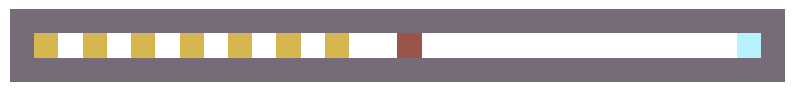

In [45]:
# Visualize the environment
plt.figure(figsize=(10, 10))
# T-Maze Environment
env = gym.make("LinearTrack-v0")
#env = gym.make("DeadlyGrid-v0")
_, obs_to_render = env.reset_with_render()
env.reset()
env.render(obs_to_render)

In [46]:
print('State space: ', env.observation_space)
print('State shape: ', env.observation_space.shape)
print('Action space: ', env.action_space)
print('Number of actions: ', env.action_space.n)

State space:  Box(0, 1, (3, 32, 4), uint8)
State shape:  (3, 32, 4)
Action space:  Discrete(3)
Number of actions:  3


# 1. Definition of model and params

In [47]:
# Discount factor
GAMMA = 0.99
# Learning rate
LEARNING_RATE = 0.001
# Capacity of the replay buffer
BUFFER_SIZE = 1000
# Update target net every ... episodes
UPDATE_EVERY= 500
# Batch size
BATCH_SIZE = 128
# Eval Episode
EVAL_EPISODE = 500
# Number of eval
N_EVAL = 50
# Hidden Units
HIDDEN_UNITS = 128
# Hidden layers
HIDDEN_LAYERS = 1
# Number of training episodes
N_EPISODES = 20000#0
# Initial value of epsilon
EPSILON_START = 1.0
# End value of epsilon
EPSILON_END = 0.01
# Epsilon decay
EPSILON_DECAY = (EPSILON_START - EPSILON_END) / N_EPISODES

In [48]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_units, hidden_layers):
        super(DQN, self).__init__()

        self.action_space_size = output_dim
        self.hidden_layers = hidden_layers
        self.layer_in = nn.Linear(input_dim, hidden_units)
        self.hidden_layer= nn.Linear(hidden_units, hidden_units)
        self.layer_out = nn.Linear(hidden_units, output_dim)

    def forward(self, x):
        x = F.relu(self.layer_in(x))
        for i in range(self.hidden_layers-1):
            x = F.relu(self.hidden_layer(x))
        x = self.layer_out(x)
        return x

    def action(self, state, epsilon):
        if random.random() > epsilon:
            state   = torch.tensor(state, dtype=torch.float32).flatten().to(device)
            q_value = self.forward(state)
            action  = int(torch.argmax(q_value, dim=-1))
        else:
            action = random.randrange(self.action_space_size)
        return action

In [49]:
def test_agent(model, gamma):
    done = False
    episode_return = 0
    i = 0
    state = env.reset()
    with torch.no_grad():
        while not done:
            action = model.action(state, 0.01)
            state, reward, done, info = env.step(action)
            episode_return += gamma**i * reward
            i += 1
    return episode_return

# 2. Baseline

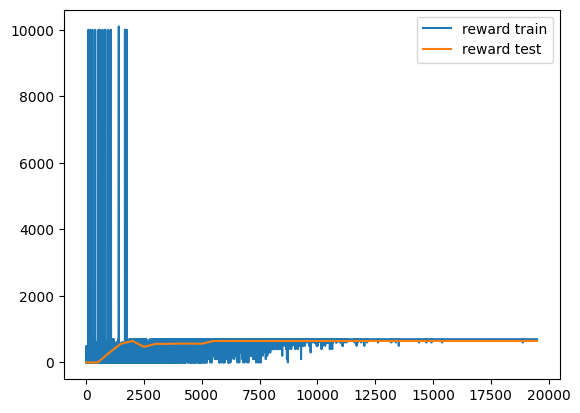

100%|██████████| 20000/20000 [22:48<00:00, 14.61it/s]


In [50]:
model_baseline = DQN(env.observation_space.shape[0] * env.observation_space.shape[1] * env.observation_space.shape[2],
                     env.action_space.n,
                     HIDDEN_UNITS,
                     HIDDEN_LAYERS).to(device)
optimizer = optim.Adam(params=model_baseline.parameters(), lr=LEARNING_RATE)

results_baseline = {
    'epochs_save' : [],
    'weights': {},
    'rewards_test': [],
    'rewards_train': []
}

step = 0
eps = EPSILON_START

for step in tqdm(range(N_EPISODES)):
    done = False
    state = env.reset()
    r_train = 0
    while not done:
        action = model_baseline.action(state, eps)
        next_state, reward, done, info = env.step(action)
        r_train += reward

        next_state_values = model_baseline(torch.tensor(next_state, dtype=torch.float32).flatten().to(device)).max().detach()
        state_action_values = model_baseline(torch.tensor(state, dtype=torch.float32).flatten().to(device))[action]

        expected_q_value = reward + GAMMA * next_state_values * (1 - done)
        loss = nn.MSELoss()(state_action_values, expected_q_value)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        state = next_state
    results_baseline['rewards_train'].append(r_train)

    if step%EVAL_EPISODE == 0:
        r_test = []
        for j in range(N_EVAL):
            r = test_agent(model_baseline, GAMMA)
            r_test.append(r)

        results_baseline['weights'][step] = model_baseline.state_dict()
        results_baseline['rewards_test'].append(np.mean(r_test))
        results_baseline['epochs_save'].append(step)

        display.clear_output(True)
        plt.plot(results_baseline['rewards_train'], label = "reward train")
        plt.plot(results_baseline['epochs_save'],results_baseline['rewards_test'], label = "reward test")
        plt.legend()
        plt.show()

    eps -= EPSILON_DECAY
    step += 1
torch.save(results_baseline, 'results_baseline.pth')

700


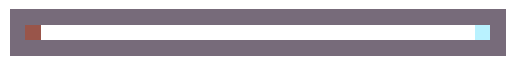

In [52]:
state, obs_to_render = env.reset_with_render()
env.render(obs_to_render)
done = False
tot_rew_test = 0
with torch.no_grad():
        while not done:
            action = model_baseline.action(state, 0)
            state, rew , done, _, obs_to_render = env.step_with_render(action)
            tot_rew_test += rew
            env.render(obs_to_render)
            display.display(plt.gcf())
            display.clear_output(wait=True)
print(tot_rew_test)

# 3. Replay Buffer

In [53]:
class ReplayBuffer:
    def __init__(self, data_names, buffer_size, batch_size):
        self.data_keys = data_names
        self.data_dict = {}
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.reset()

    def reset(self):
        for name in self.data_keys:
            self.data_dict[name] = deque(maxlen=self.buffer_size)

    def push(self, data):
        """Add a transition to the buffer."""
        for key in self.data_keys:
            self.data_dict[key].append(data[key])

    def sample(self):
        """Sample a batch of transitions."""
        indices = random.sample(range(len(self)), self.batch_size)
        batch = [{key: self.data_dict[key][i] for key in self.data_keys} for i in indices]
        return batch

    def __len__(self):
        return len(next(iter(self.data_dict.values())))

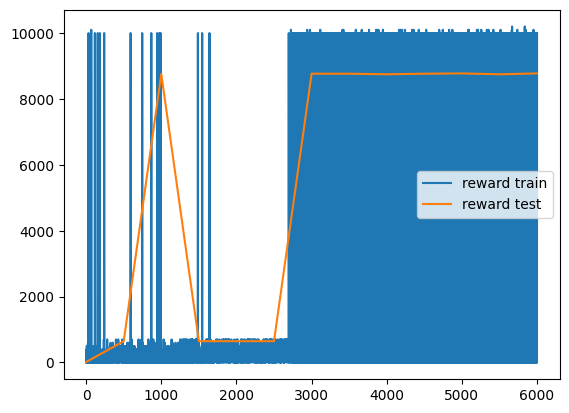

 32%|███▏      | 6337/20000 [24:49<51:03,  4.46it/s]

In [ ]:
model_replay_buffer = DQN(env.observation_space.shape[0] * env.observation_space.shape[1] * env.observation_space.shape[2],
                          env.action_space.n,
                          HIDDEN_UNITS,
                          HIDDEN_LAYERS).to(device)

replay_buffer = ReplayBuffer(['state', 'action', 'reward', 'next_state', 'done'],
                             BUFFER_SIZE, BATCH_SIZE)

optimizer = optim.Adam(params=model_replay_buffer.parameters(), lr=LEARNING_RATE)

step = 0

results_rb = {
    'epochs_save' : [],
    'weights': {},
    'rewards_test': [],
    'rewards_train': []
}

eps = EPSILON_START
for step in tqdm(range(N_EPISODES)):
    done = False
    state = env.reset()
    r_train = 0
    while not done:
        action = model_replay_buffer.action(state, eps)
        next_state, reward, done, info = env.step(action)
        replay_buffer.push({'state':state, 'action':action, 'reward':reward,
                            'next_state':next_state, 'done':done})
        r_train += reward

    results_rb['rewards_train'].append(r_train)

    if len(replay_buffer) > replay_buffer.batch_size:
        batch = replay_buffer.sample()
        for b in batch:
            next_state_values = model_replay_buffer(torch.tensor(b['next_state'], dtype=torch.float32).flatten().to(device)).max().detach()
            state_action_values = model_replay_buffer(torch.tensor(b['state'], dtype=torch.float32).flatten().to(device))[b['action']]

            expected_q_value = b['reward'] + GAMMA * next_state_values * (1 - b['done'])
            loss = nn.MSELoss()(state_action_values, expected_q_value)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    if step%EVAL_EPISODE == 0:
        r_test = []
        for j in range(10):
            r = test_agent(model_replay_buffer, GAMMA)
            r_test.append(r)
        results_rb['weights'][step] = model_replay_buffer.state_dict()
        results_rb['rewards_test'].append(np.mean(r_test))
        results_rb['epochs_save'].append(step)

        display.clear_output(True)
        plt.plot(results_rb['rewards_train'], label = "reward train")
        plt.plot(results_rb['epochs_save'],results_rb['rewards_test'], label = "reward test")
        plt.legend()
        plt.show()

    eps -= EPSILON_DECAY
    step += 1
torch.save(results_rb, 'results_rb.pth')

KeyboardInterrupt: 

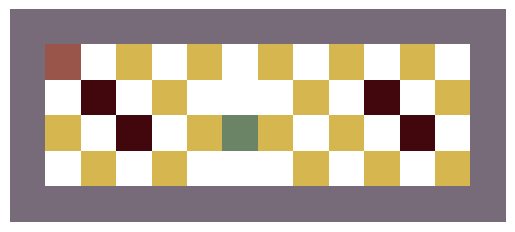

In [43]:
state, obs_to_render = env.reset_with_render()
env.render(obs_to_render)
done = False
tot_rew_test = 0
with torch.no_grad():
        while not done:
            action = model_replay_buffer.action(state, 0)
            state, rew , done, _, obs_to_render = env.step_with_render(action)
            tot_rew_test += rew
            env.render(obs_to_render)
            display.display(plt.gcf())
            display.clear_output(wait=True)
print(tot_rew_test)

# 4. Target Network

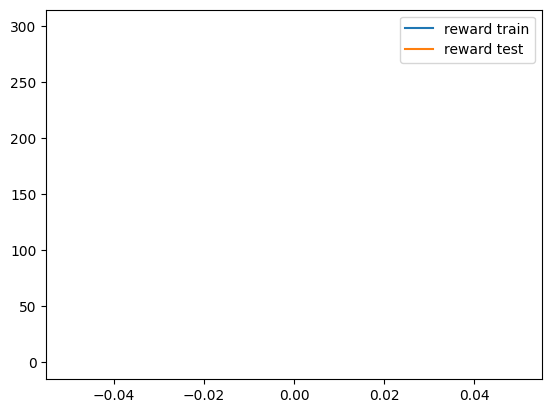

100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


In [44]:
model_tn = DQN(env.observation_space.shape[0] * env.observation_space.shape[1] * env.observation_space.shape[2],
                          env.action_space.n,
                          HIDDEN_UNITS,
                          HIDDEN_LAYERS).to(device)

model_tn_target = DQN(env.observation_space.shape[0] * env.observation_space.shape[1] * env.observation_space.shape[2],
                          env.action_space.n,
                          HIDDEN_UNITS,
                          HIDDEN_LAYERS).to(device)

model_tn_target.load_state_dict(model_tn.state_dict())

replay_buffer = ReplayBuffer(['state', 'action', 'reward', 'next_state', 'done'],
                             BUFFER_SIZE, BATCH_SIZE)

optimizer = optim.Adam(params=model_tn.parameters(), lr=LEARNING_RATE)

step = 0

results_tm = {
    'epochs_save' : [],
    'weights': {},
    'rewards_test': [],
    'rewards_train': []
}

eps = EPSILON_START
for step in tqdm(range(N_EPISODES)):
    done = False
    state = env.reset()
    r_train = 0
    while not done:
        action = model_tn.action(state, eps)
        next_state, reward, done, info = env.step(action)
        replay_buffer.push({'state':state, 'action':action, 'reward':reward,
                            'next_state':next_state, 'done':done})
        r_train += reward

    results_tm['rewards_train'].append(r_train)

    if len(replay_buffer) > replay_buffer.batch_size:
        batch = replay_buffer.sample()
        for b in batch:

            next_state_values = model_tn_target(torch.tensor(b['next_state'], dtype=torch.float32).flatten().to(device)).max().detach()
            state_action_values = model_tn(torch.tensor(b['state'], dtype=torch.float32).flatten().to(device))[b['action']]

            expected_q_value = b['reward'] + GAMMA * next_state_values * (1 - b['done'])

            loss = nn.MSELoss()(state_action_values, expected_q_value)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    if step % UPDATE_EVERY == 0:
        model_tn_target.load_state_dict(model_tn.state_dict())

    if step%EVAL_EPISODE == 0:
        r_test = []
        for j in range(10):
            r = test_agent(model_tn, GAMMA)
            r_test.append(r)
        results_tm['weights'][step] = model_tn.state_dict()
        results_tm['rewards_test'].append(np.mean(r_test))
        results_tm['epochs_save'].append(step)

        display.clear_output(True)
        plt.plot(results_tm['rewards_train'], label = "reward train")
        plt.plot(results_tm['epochs_save'], results_tm['rewards_test'], label = "reward test")
        plt.legend()
        plt.show()

    eps -= EPSILON_DECAY
    step += 1
torch.save(results_tm, 'results_tm.pth')

# 5. Loss Function Comparaison

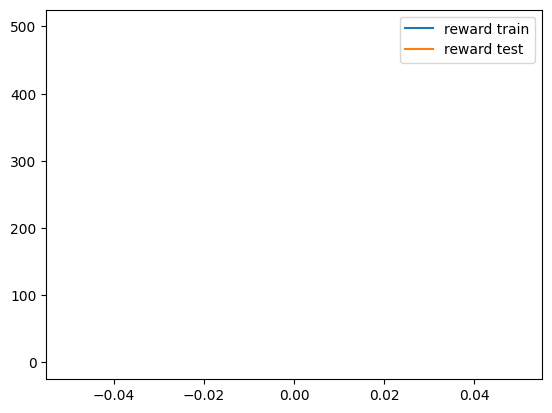

100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


In [45]:
model_lf = DQN(env.observation_space.shape[0] * env.observation_space.shape[1] * env.observation_space.shape[2],
                          env.action_space.n,
                          HIDDEN_UNITS,
                          HIDDEN_LAYERS).to(device)

model_lf_target = DQN(env.observation_space.shape[0] * env.observation_space.shape[1] * env.observation_space.shape[2],
                          env.action_space.n,
                          HIDDEN_UNITS,
                          HIDDEN_LAYERS).to(device)

model_lf_target.load_state_dict(model_lf.state_dict())

replay_buffer = ReplayBuffer(['state', 'action', 'reward', 'next_state', 'done'],
                             BUFFER_SIZE, BATCH_SIZE)

optimizer = optim.Adam(params=model_lf.parameters(), lr=LEARNING_RATE)

results_lf = {
    'epochs_save' : [],
    'weights': {},
    'rewards_test': [],
    'rewards_train': []
}

step = 0
eps = EPSILON_START
for step in tqdm(range(N_EPISODES)):
    done = False
    state = env.reset()
    r_train = 0
    while not done:
        action = model_lf.action(state, eps)
        next_state, reward, done, info = env.step(action)
        replay_buffer.push({'state':state, 'action':action, 'reward':reward,
                            'next_state':next_state, 'done':done})
        r_train += reward

    results_lf['rewards_train'].append(r_train)

    if len(replay_buffer) > replay_buffer.batch_size:
        batch = replay_buffer.sample()
        for b in batch:

            next_state_values = model_lf_target(torch.tensor(b['next_state'], dtype=torch.float32).flatten().to(device)).max().detach()
            state_action_values = model_lf(torch.tensor(b['state'], dtype=torch.float32).flatten().to(device))[b['action']]

            expected_q_value = b['reward'] + GAMMA * next_state_values * (1 - b['done'])

            loss = nn.SmoothL1Loss()(state_action_values, expected_q_value)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    if step % UPDATE_EVERY == 0:
        model_lf_target.load_state_dict(model_lf.state_dict())

    if step%EVAL_EPISODE == 0:
        r_test = []
        for j in range(10):
            r = test_agent(model_lf, GAMMA)
            r_test.append(r)
        results_lf['weights'][step] = model_lf.state_dict()
        results_lf['rewards_test'].append(np.mean(r_test))
        results_lf['epochs_save'].append(step)

        display.clear_output(True)
        plt.plot(results_lf['rewards_train'], label = "reward train")
        plt.plot(results_lf['epochs_save'], results_lf['rewards_test'], label = "reward test")
        plt.legend()
        plt.show()

    eps -= EPSILON_DECAY
    step += 1
torch.save(results_lf, 'results_lf.pth')

# 6.Hyperparameter Intuition

# 7. Behavioural Analysis

# 8. Prioritized Experience Replay